# **Time Series: Autoregression and ARIMA**



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.8.0-py3-none-any.whl size=12587 sha256=49322695498a5eee7b31d427092686f34f91fc49807a32915606639593b8b786
  Stored in directory: /root/.cache/pip/wheels/ca/a9/1f/90c7a8a37ac37ff0fa0a27b2152f9b24be8910448ab93992f8
Successfully built empiricaldist
Downloaded thinkstats.py
Downloaded Net_generation_for_all_sectors.csv


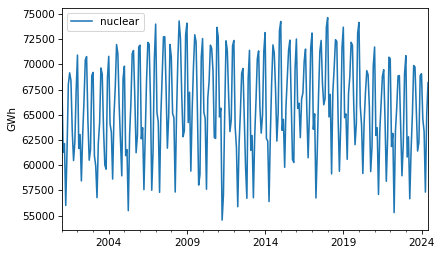

In [ ]:
#Env set up
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

#datasets and functions
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")

nuclear = elec["United States : nuclear"]
nuclear.plot(label="nuclear")

decorate(ylabel="GWh")

def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

# Autocorrelation

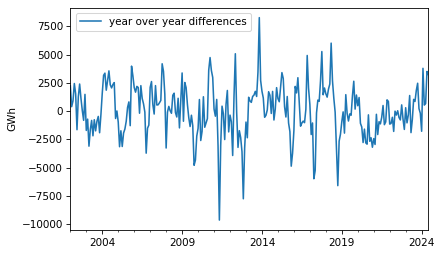

In [ ]:
#loading the dataset
diff = (nuclear - nuclear.shift(12)).dropna() #computing the year over year differences

diff.plot(label="year over year differences")
decorate(ylabel="GWh")

In [ ]:
df_ar = pd.DataFrame({"diff": diff})
for lag in [1, 2, 3]:
    df_ar[f"lag{lag}"] = diff.shift(lag)

df_ar = df_ar.dropna()
df_ar

,diff,lag1,lag2,lag3
2002-04-30,2434.0,900.0,386.0,2219.0
2002-05-31,1520.0,2434.0,900.0,386.0
2002-06-30,-1651.0,1520.0,2434.0,900.0
2002-07-31,1255.0,-1651.0,1520.0,2434.0
2002-08-31,2389.0,1255.0,-1651.0,1520.0
...,...,...,...,...
2024-02-29,3777.0,-1790.0,-196.0,217.0
2024-03-31,526.0,3777.0,-1790.0,-196.0
2024-04-30,664.0,526.0,3777.0,-1790.0
2024-05-31,3500.0,664.0,526.0,3777.0


In [ ]:
df_ar.corr()[["diff"]]

,diff
diff,1.000000
lag1,0.562212
lag2,0.292454
lag3,0.222228


In [ ]:
def make_formula(df):
    """Make a Patsy formula from column names."""
    y = df.columns[0]
    xs = " + ".join(df.columns[1:])
    return f"{y} ~ {xs}"

In [ ]:
import statsmodels.formula.api as smf

formula = make_formula(df_ar)
results_ar = smf.ols(formula=formula, data=df_ar).fit()

In [ ]:
from thinkstats import display_summary

display_summary(results_ar)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,24.2674,114.674,0.212,0.833,-201.528,250.063
lag1,0.5847,0.061,9.528,0.000,0.464,0.706
lag2,-0.0908,0.071,-1.277,0.203,-0.231,0.049
lag3,0.1026,0.062,1.666,0.097,-0.019,0.224


R-squared:,0.3239


In [ ]:
pred_ar = results_ar.predict(df_ar)

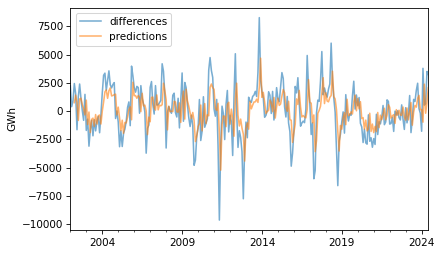

In [ ]:
diff.plot(alpha=0.6, label="differences")
pred_ar.plot(alpha=0.6, label="predictions")
decorate(ylabel="GWh")

In [ ]:
resid_ar = (diff - pred_ar).dropna()
R2 = 1 - resid_ar.var() / diff.var()
R2

0.3190252265690784

# Moving Average

In [ ]:
df_ma = pd.DataFrame({"resid": resid_ar})

for lag in [1, 6]:
    df_ma[f"lag{lag}"] = resid_ar.shift(lag)

df_ma = df_ma.dropna()

In [ ]:
formula = make_formula(df_ma)
results_ma = smf.ols(formula=formula, data=df_ma).fit()
display_summary(results_ma)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-14.0016,114.697,-0.122,0.903,-239.863,211.860
lag1,0.0014,0.062,0.023,0.982,-0.120,0.123
lag6,-0.1592,0.063,-2.547,0.011,-0.282,-0.036


R-squared:,0.0247


In [ ]:
#R squared is poor but the p value of the 6th lag is good indicating chance

#using the model to generate retrodiction
pred_ma = results_ma.predict(df_ma)
pred_ma

,0
2002-10-31,-283.273243
2002-11-30,-33.039442
2002-12-31,372.312960
2003-01-31,-343.301499
2003-02-28,-228.769157
...,...
2024-02-29,-72.088819
2024-03-31,-242.591426
2024-04-30,-229.436609
2024-05-31,172.777451


In [ ]:
#retrodictions for year over year
pred_diff = pred_ar + pred_ma
pred_diff

,0
2002-04-30,NaN
2002-05-31,NaN
2002-06-30,NaN
2002-07-31,NaN
2002-08-31,NaN
...,...
2024-02-29,-1054.390540
2024-03-31,2132.586145
2024-04-30,-424.274037
2024-05-31,925.010412


In [ ]:
#r squared
resid_ma = (diff - pred_diff).dropna()

R2 = 1 - resid_ma.var() / diff.var()
R2

0.33151010013912285

In [ ]:
#retrodiction with autoregression
pred_diff = pd.Series(pred_diff, index=nuclear.index)
pred_diff

,0
2001-01-31,NaN
2001-02-28,NaN
2001-03-31,NaN
2001-04-30,NaN
2001-05-31,NaN
...,...
2024-02-29,-1054.390540
2024-03-31,2132.586145
2024-04-30,-424.274037
2024-05-31,925.010412


In [ ]:
n_missing = pred_diff.isna().sum()
n_missing

np.int64(21)

In [ ]:
#That's because we shifted the Series by 12 months to compute year-over-year differences, then we shifted the differences 3 months for the first autoregression model,
#and we shifted the residuals of the first model by 6 months for the second model. Each time we shift a series like this, we lose a few values at the beginning of the Series,
#and the sum of these shifts is 21. So before we can generate retrodictions, we have to prime the pump by copying the first 21 elements from the original into a new Series.

pred_series = pd.Series(index=nuclear.index, dtype=float)
pred_series.iloc[:n_missing] = nuclear.iloc[:n_missing]

In [ ]:
for i in range(n_missing, len(pred_series)):
    pred_series.iloc[i] = pred_series.iloc[i - 12] + pred_diff.iloc[i]

In [ ]:
pred_series[:n_missing] = np.nan

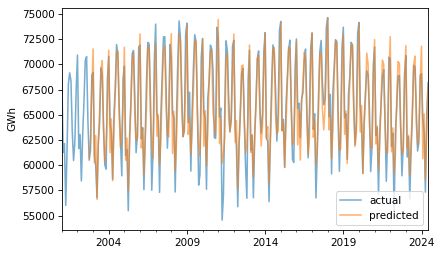

In [ ]:
nuclear.plot(label="actual", alpha=0.6)
pred_series.plot(alpha=0.6, label="predicted")

decorate(ylabel="GWh")

In [ ]:
resid = (nuclear - pred_series).dropna()
R2 = 1 - resid.var() / nuclear.var()
R2

0.8586566911201015

The model we used to compute these retrodictions is called SARIMA, which is one of a family of models called ARIMA. Each part of these acronyms refers to an element of the model.

S stands for seasonal, because the first step was to compute differences between values separated by one seasonal period.

AR stands for autoregression, which we used to model lagged correlations in the differences.

I stands for integrated, because the iterative process we used to compute pred_series is analogous to integration in calculus.

MA stands for moving average, which is the conventional name for the second autoregression model we ran with the residuals from the first.

ARIMA models are powerful and versatile tools for modeling time series data.

# **ARIMA**